<a href="https://colab.research.google.com/github/mishra28soumya/TensorFlow-for-Deep-Learning/blob/master/Cats_vs_Dogs_without_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dogs vs Cats Image Classification Without Image Augmentation
We'll build an image classifier using `tf.keras.Sequential` model and load data using `tf.keras.preprocessing.image.ImageDataGenerator`.

# Importing packages
We'll need TensorFlow Datasets, an API that simplifies downloading and accessing datasets, and provides several sample datasets to work with.

1. os — to read files and directory structure
2. numpy — for some matrix math outside of TensorFlow
3. matplotlib.pyplot — to plot the graph and display images in our training and validation data

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf 

TensorFlow 2.x selected.


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
# Helper libraries
import os
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Data Loading
The dataset we are using is a filtered version of Dogs vs. Cats dataset from Kaggle.
Here we will use the class `tf.keras.preprocessing.image.ImageDataGenerator `which will read data from disk. We therefore need to directly download Dogs vs. Cats from a URL and unzip it to the Colab filesystem.

In [6]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=_URL, extract=True)

68608000/68606236 [==============================] - 1s 0us/step


In [7]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs


Assign variables with the proper file path for the training and validation sets.

In [0]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Explore the data
Let us check how many cats and dogs images we have in our training and validation directory

In [0]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [10]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


# Setting Model Parameter



In [0]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels


#Data Preparation
Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. The steps involved in preparing these images are:


1.   Read images from the disk
2.   Decode contents of these images and convert it into proper grid format as per their RGB content
3.   Convert them into floating point tensors
4.   Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.




In [0]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

After defining our generators for training and validation images, flow_from_directory method will load images from the disk, applying rescaling, and resize them.



In [13]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                          directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE),
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [14]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                          directory=validation_dir,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE),
                                                           class_mode='binary')

Found 1000 images belonging to 2 classes.


<h3> Visualizing Training images</h3>
We can visualize our training images by getting a batch of images from the training generator, and then plotting a few of them using matplotlib.

In [0]:
sample_training_images, _ = next(train_data_gen)

The next function returns a batch from the dataset. One batch is a tuple of (many images, many labels). 

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

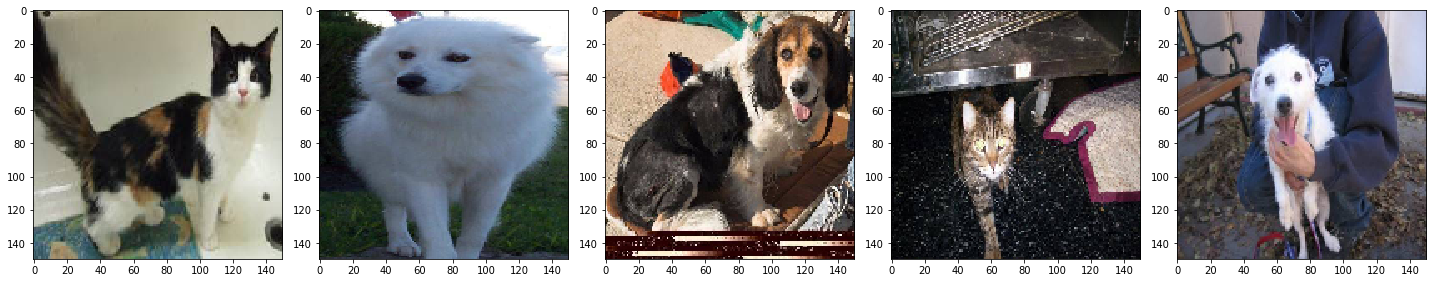

In [17]:
plotImages(sample_training_images[:5])

<h2>Model Creation</h2>
Building the neural network requires configuring the layers of the model, then compiling the model.

<h3>Define the model</h3>
The model consists of four convolution blocks with a max pool layer in each of them. Then we have a fully connected layer with 512 units, with a relu activation function. The model will output class probabilities for two classes — dogs and cats — using softmax.


In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

<h3>Model Summary</h3>

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

# Train the model
Since our batches are coming from a generator (ImageDataGenerator), we'll use fit_generator instead of fit.


In [21]:
EPOCHS = 100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Train for 20 steps, validate for 10 steps
Epoch 1/100
20/20 [==============================] - 106s 5s/step - loss: 0.7169 - accuracy: 0.4985 - val_loss: 0.6945 - val_accuracy: 0.5000
Epoch 2/100
20/20 [==============================] - 103s 5s/step - loss: 0.6929 - accuracy: 0.5250 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 3/100
20/20 [==============================] - 103s 5s/step - loss: 0.6909 - accuracy: 0.5510 - val_loss: 0.6845 - val_accuracy: 0.5170
Epoch 4/100
20/20 [==============================] - 103s 5s/step - loss: 0.6758 - accuracy: 0.5725 - val_loss: 0.6681 - val_accuracy: 0.6250
Epoch 5/100
20/20 [==============================] - 103s 5s/step - loss: 0.6689 - accuracy: 0.5950 - val_loss: 0.6906 - val_accuracy: 0.5550
Epoch 6/100
20/20 [==============================] - 103s 5s/step - loss: 0.6621 - accuracy: 0.5885 - val_loss: 0.6379 - val_accuracy: 0.6090
Epoch 7/100
20/20 [==============================] - 104s 5s/step - loss: 0.6188 - accuracy: 0.6730 - val_

<h3>Visualizing results of the training</h3>

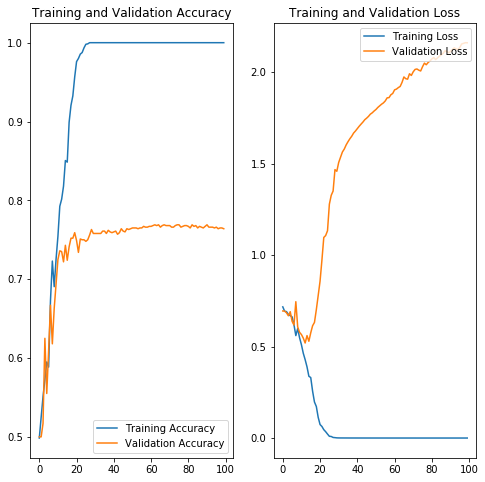

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()